## Cosine similarity algorithm

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load preference data
preference_df = pd.read_csv("synthetic-dataset/preference.csv")
user_item_matrix = preference_df.pivot(index='user_id', columns='activity_id', values='preference').fillna(0)

# Adjust preference values
user_item_matrix[user_item_matrix == -1] = np.nan

print(user_item_matrix.head())
# count nan values
print(user_item_matrix.isnull().sum().sum()) 
# count total values
user_item_matrix.size
# total non nan values
print(user_item_matrix.count().sum())

activity_id  0         1         2    3         4         5         6    7    \
user_id                                                                        
0            NaN       NaN       NaN  NaN       NaN  0.467129       NaN  NaN   
1            NaN       NaN       NaN  NaN  0.362345       NaN       NaN  NaN   
2            NaN  0.947865       NaN  NaN       NaN       NaN       NaN  NaN   
3            NaN       NaN       NaN  NaN       NaN       NaN  0.945527  NaN   
4            NaN  0.122903  0.452146  NaN       NaN       NaN       NaN  NaN   

activity_id  8         9    ...  102       103       104       105  106  \
user_id                     ...                                           
0            NaN       NaN  ...  NaN       NaN       NaN       NaN  NaN   
1            NaN  0.979025  ...  NaN       NaN       NaN       NaN  NaN   
2            NaN       NaN  ...  NaN  0.412991       NaN  0.399586  NaN   
3            NaN       NaN  ...  NaN  0.469595  0.137711       N

In [3]:
# see how cosine similarity works
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
import numpy as np

a = np.array([0, 2, 4])
b = np.array([1, 4, 2])
a = a -np.mean(a).repeat(len(a))
b = b - np.mean(b).repeat(len(b))
a = a / np.linalg.norm(a)
b = b / np.linalg.norm(b)
mat = np.stack((a, b), axis=0)

print(spatial.distance.cosine(a, b))
print(cosine_similarity(mat))

0.6726731646460115
[[1.         0.32732684]
 [0.32732684 1.        ]]


In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

# Load preference data
preference_df = pd.read_csv("synthetic-dataset/preference.csv")
user_item_matrix = preference_df.pivot(index='user_id', columns='activity_id', values='preference')

# Replace -1 with NaN to indicate missing data
user_item_matrix.replace(-1, np.nan, inplace=True)

# Fill NaN values with the mean of each user's preferences for the purpose of computing similarities
mean_user_preferences = user_item_matrix.mean(axis=1)
mean_user_preferences = mean_user_preferences.fillna(mean_user_preferences.mean())
user_item_matrix_filled = user_item_matrix.T.fillna(mean_user_preferences).T

# Compute cosine similarity between users
user_similarity_matrix = cosine_similarity(user_item_matrix_filled)

print("Dimensions of user similarity matrix:", user_similarity_matrix.shape)
print("Number of users:", user_similarity_matrix.shape[0])
print("Number of items:", user_item_matrix_filled.shape[1])
print("length of one row of user item matrix:", len(user_item_matrix_filled.iloc[0]))

# Function to predict preferences
def predict_preferences(user_id):
    # Weights are the similarities with other users
    weights = user_similarity_matrix[user_id]
    # Get the ratings from all users
    ratings = user_item_matrix_filled.values
    # Compute the weighted sum of ratings
    weighted_ratings = np.dot(weights, ratings)
    # Compute the sum of weights
    sum_of_weights = np.array([np.abs(weights).sum() for _ in range(ratings.shape[1])])
    # Predicted preferences
    predicted_preferences = weighted_ratings / sum_of_weights
    # Replace known values with original to not predict them
    predicted_preferences[user_item_matrix.iloc[user_id].notna().values] = user_item_matrix.iloc[user_id].values[user_item_matrix.iloc[user_id].notna().values]
    return predicted_preferences

# Example: predict preferences for user 0
predicted_preferences_user_0 = predict_preferences(0)
print("Predicted preferences for user 0:", predicted_preferences_user_0)


Dimensions of user similarity matrix: (50, 50)
Number of users: 50
Number of items: 112
length of one row of user item matrix: 112
Predicted preferences for user 0: [0.40096788 0.43504847 0.42062394 0.39735163 0.41409913 0.4671293
 0.42844352 0.41648886 0.39159219 0.42277709 0.42354304 0.42995743
 0.42693368 0.43964985 0.42974662 0.42299322 0.39058852 0.34748638
 0.43711889 0.43033181 0.42298422 0.42565464 0.40483332 0.43674444
 0.40960037 0.42499831 0.36133339 0.4324046  0.41301778 0.41346579
 0.7168039  0.41919052 0.44109384 0.42837728 0.39342592 0.42184039
 0.4044023  0.39695641 0.71507495 0.39861614 0.43212591 0.42253577
 0.43192204 0.27663036 0.43204495 0.4174741  0.41921652 0.43287905
 0.34128456 0.42230405 0.42478648 0.40094284 0.41753082 0.44234542
 0.45959583 0.42663837 0.40725242 0.44506997 0.41972025 0.42498317
 0.4430424  0.42543413 0.41573771 0.40884764 0.42384457 0.4120095
 0.43537013 0.42709261 0.41443393 0.43123971 0.43805804 0.08996806
 0.42335761 0.41829181 0.43250007

### MAE Evaluation

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Predict preferences for all user-item pairs
all_predictions = np.zeros_like(user_item_matrix.values)
for i in range(user_item_matrix.shape[0]):
    all_predictions[i, :] = predict_preferences(i)

# Calculate MSE
mse = mean_squared_error(user_item_matrix_filled.values.flatten(), all_predictions.flatten())
mae = mean_absolute_error(user_item_matrix_filled.values.flatten(), all_predictions.flatten())
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)


Mean Squared Error: 0.006918491668441829
Mean Absolute Error: 0.06287351763563424


### Make some analysis on the predictions

Not Rated activities: [  0   1   2   3   5   6   7   8  10  11  12  13  15  16  17  18  19  21
  22  23  24  26  27  29  32  33  34  35  36  37  38  39  40  42  43  44
  45  46  48  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65
  66  68  69  70  71  72  73  74  75  76  77  79  80  82  85  87  88  89
  90  91  93  94  95  96  97  99 101 102 104 105 106 108 109 110 111]
User ID: 7
True user conditions: 3
Top activities: ["Giocare a 'indovina l'oggetto' con scatole sensoriali"
 'Organizzare giochi di squadra semplici'
 'Decorare una pagina con adesivi colorati'
 'Attività di pittura adattata con pennelli speciali'
 "Gioco dell'oca con immagini tattili"]
Target conditions: [0 1 1 2 1]


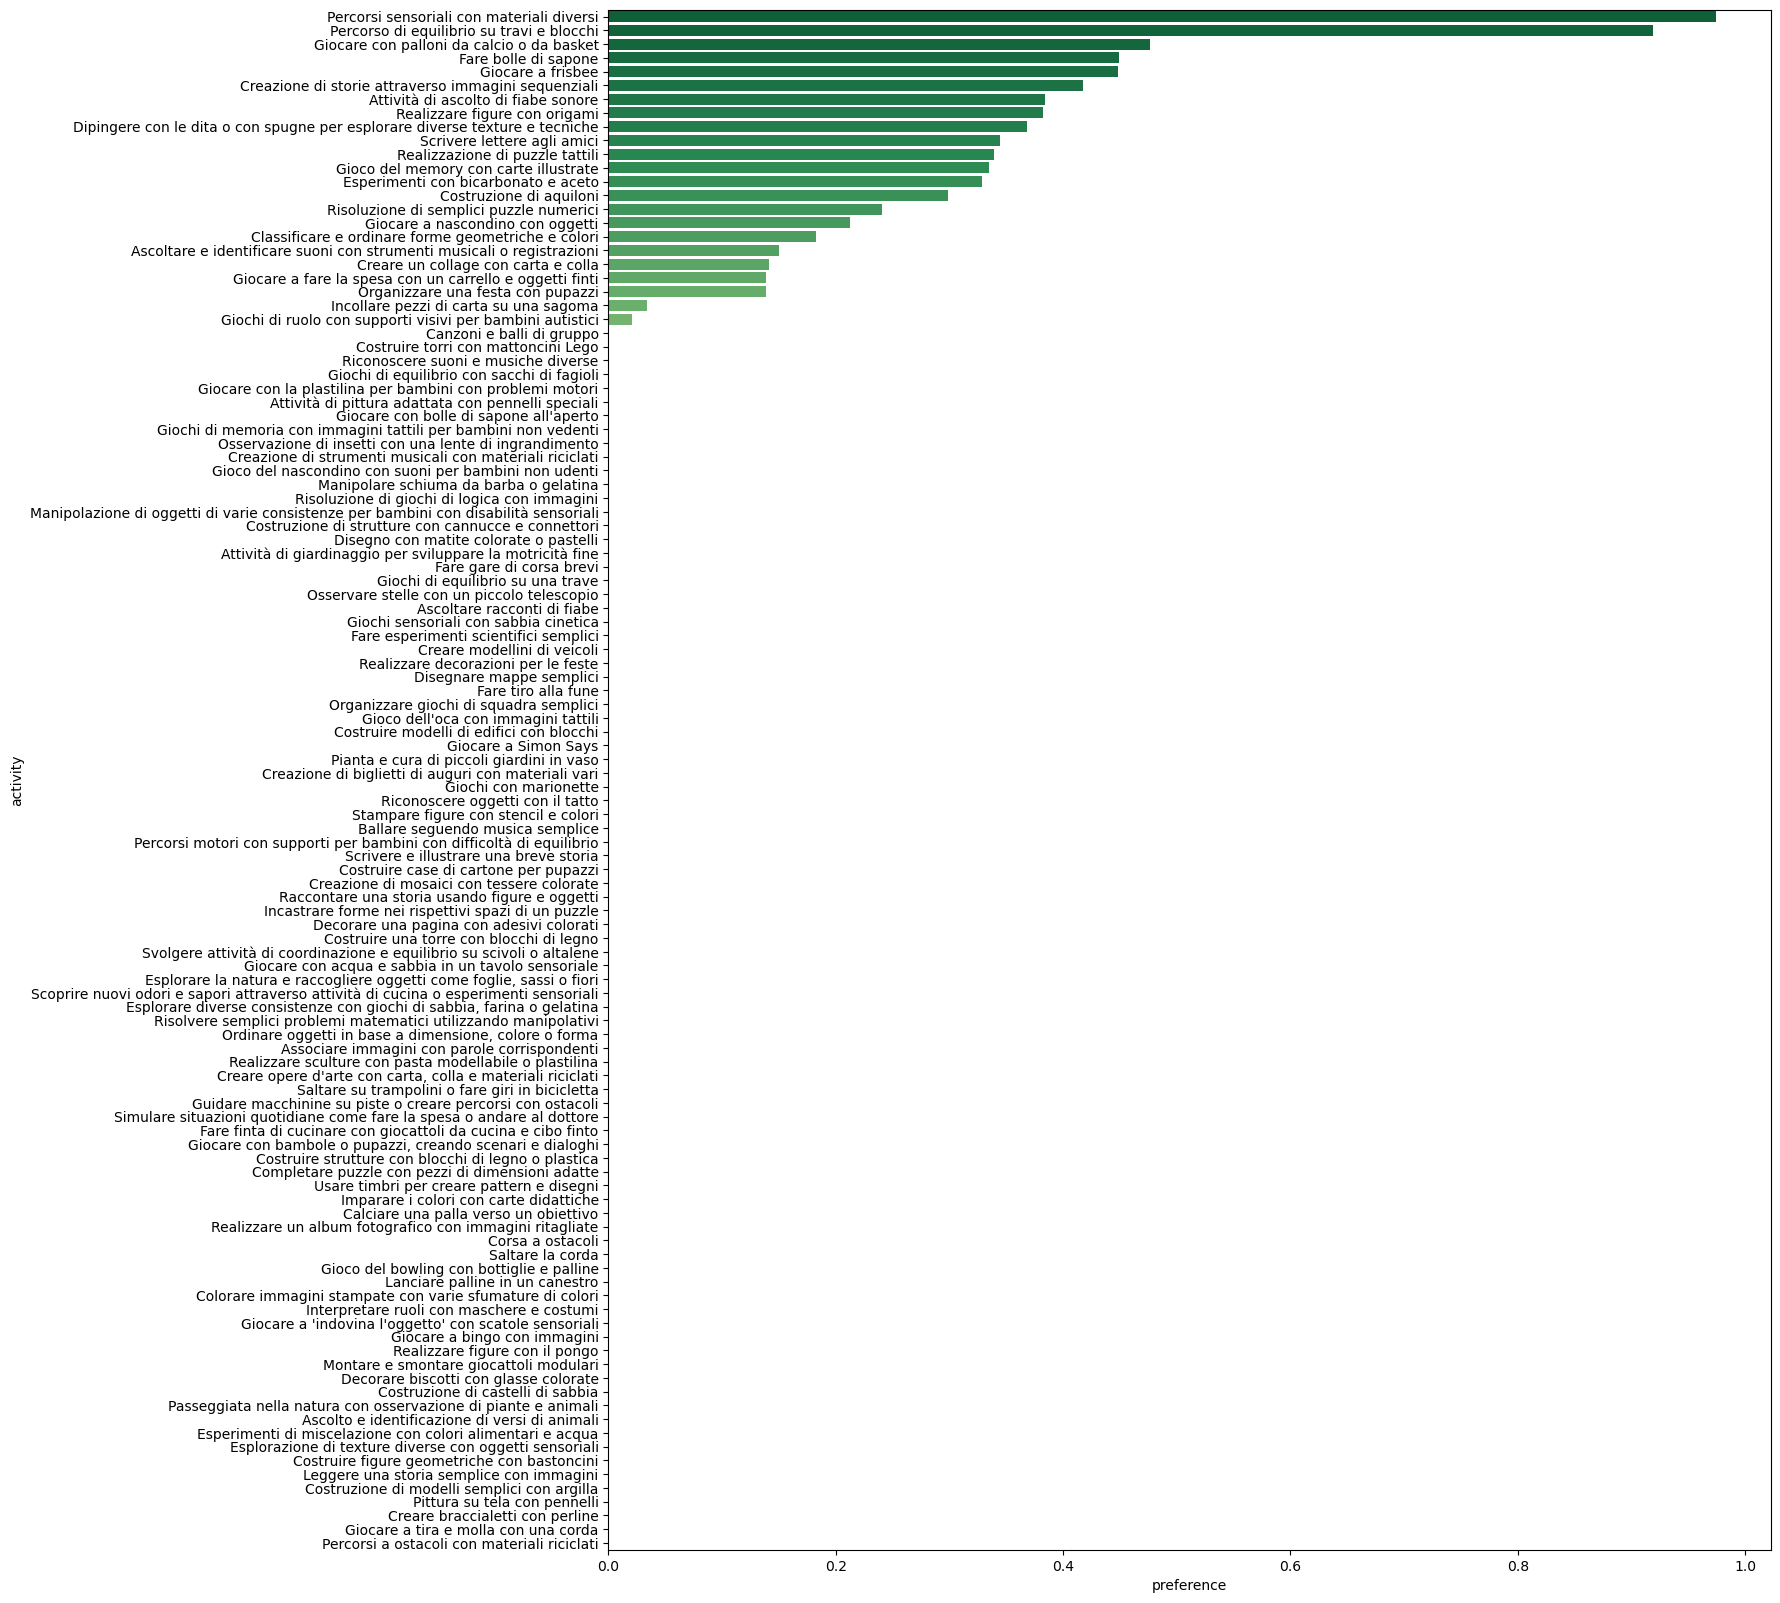

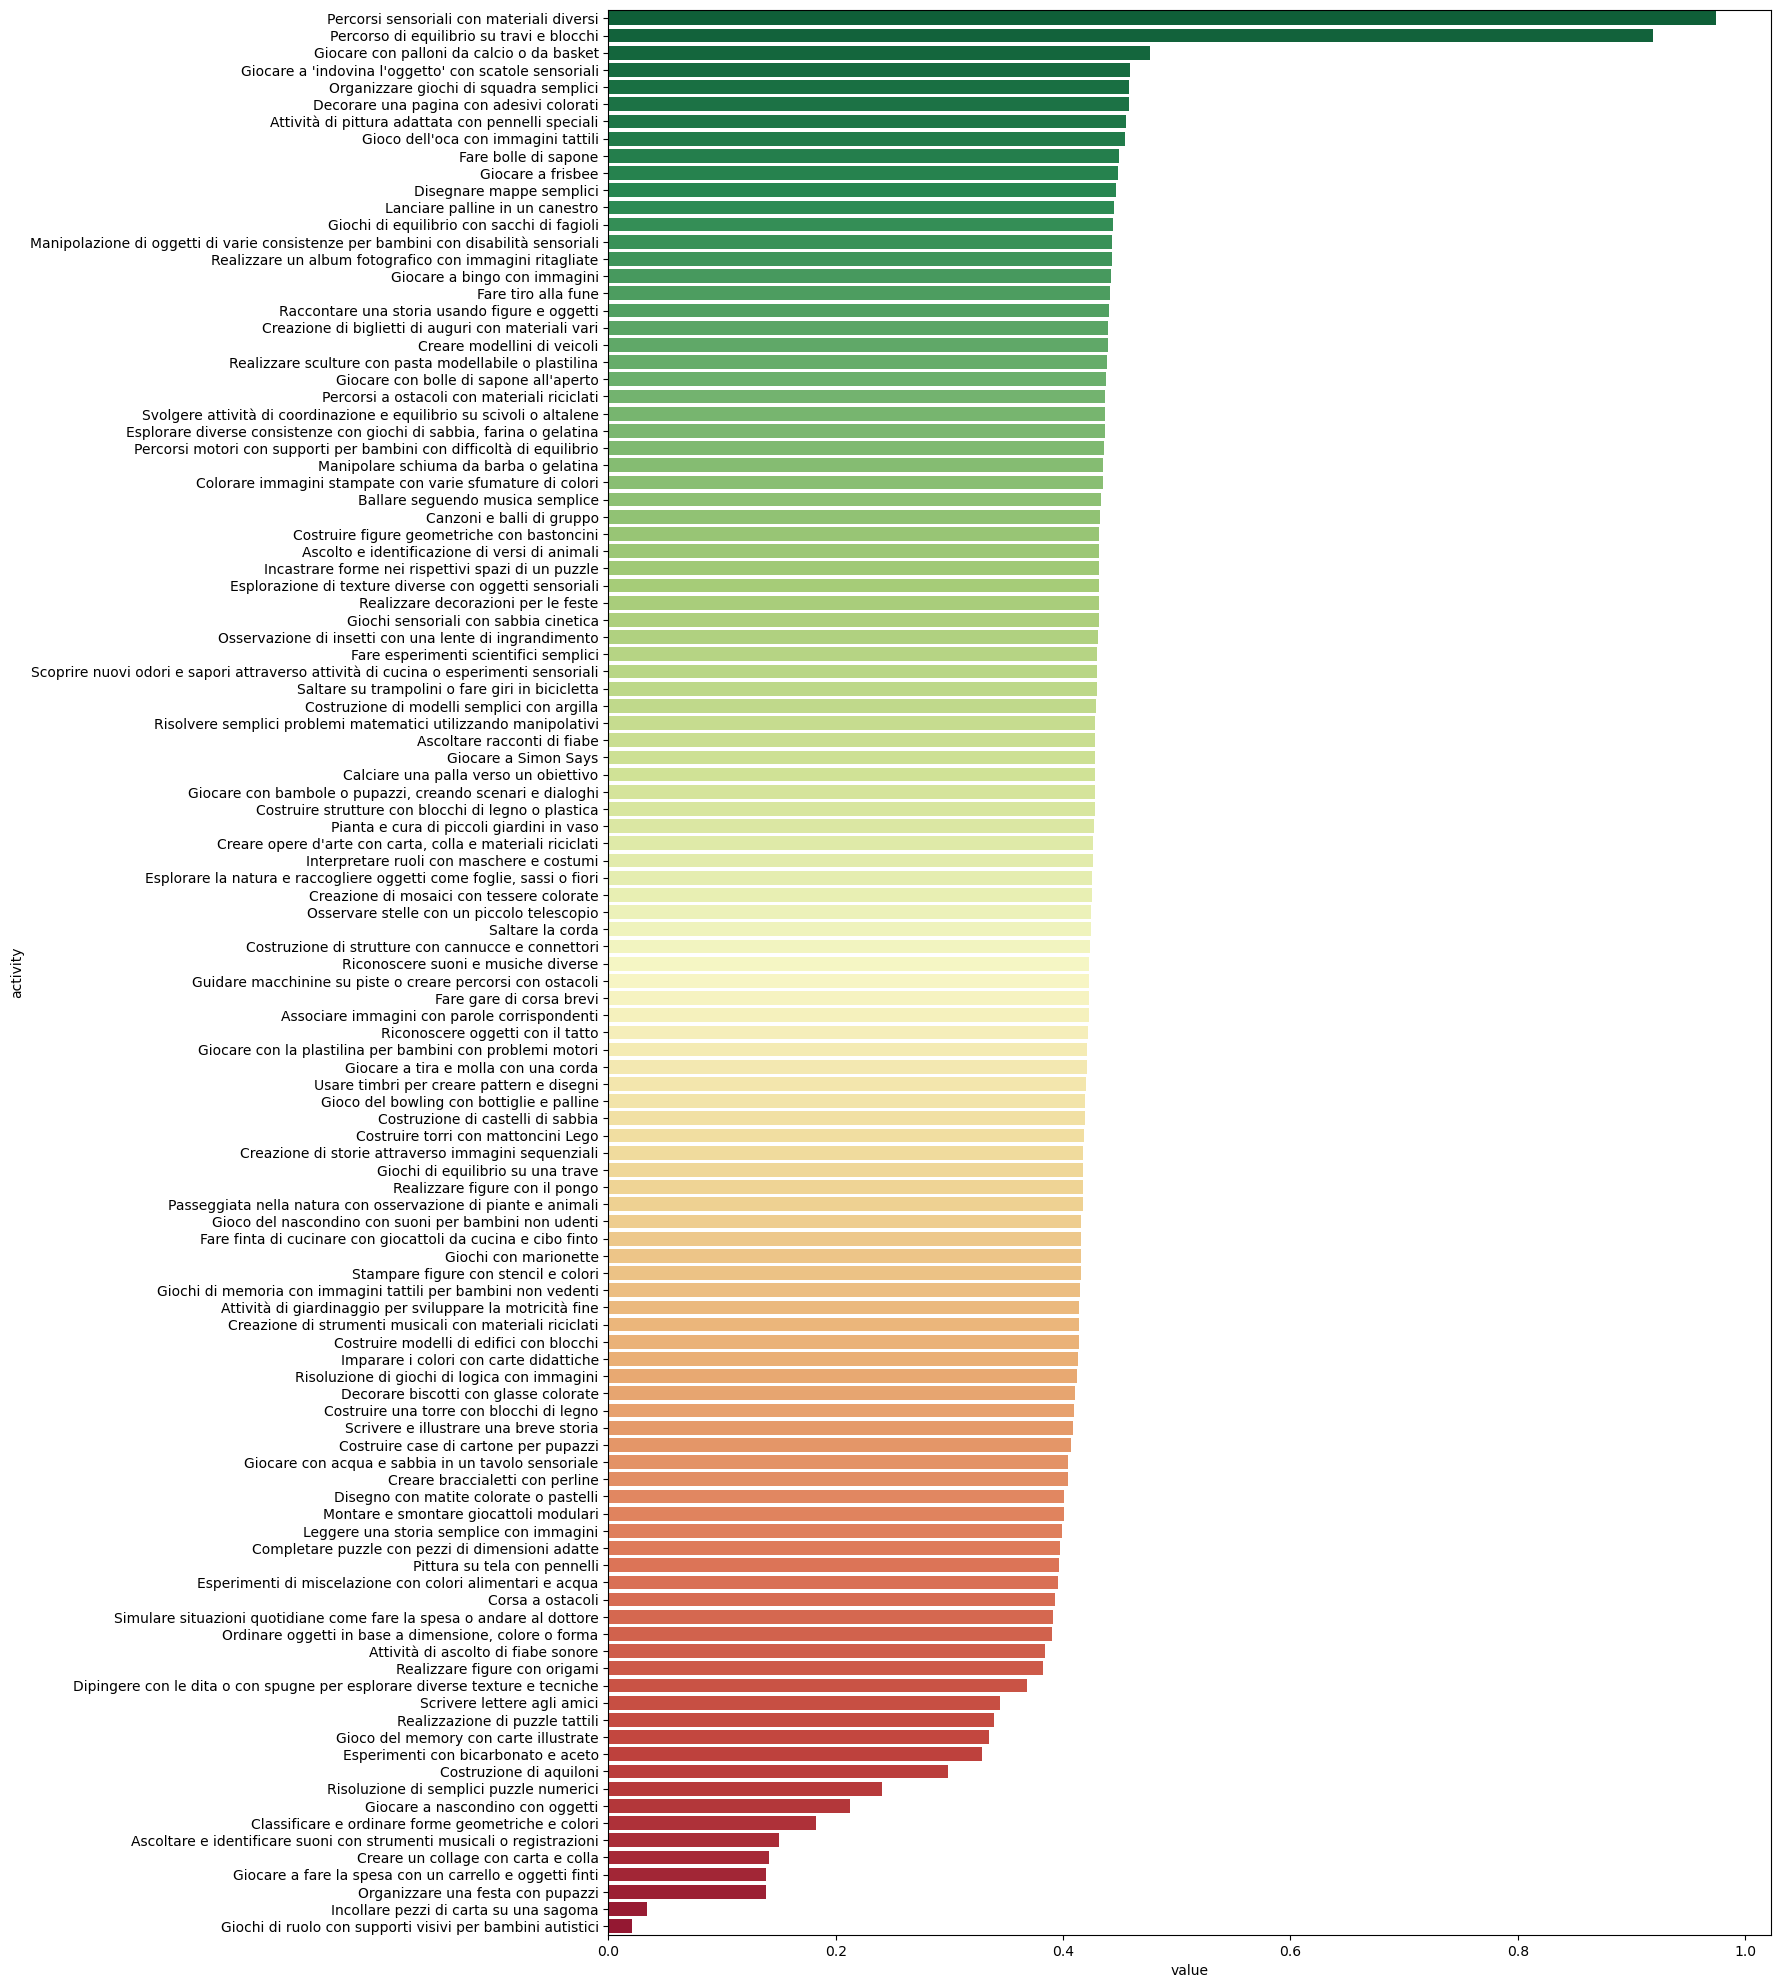

In [70]:
users = pd.read_csv("synthetic-dataset/user.csv")
activities = pd.read_csv("synthetic-dataset/activity.csv", sep='|')
user_id = np.random.choice(users['user_id'])
old_preferences_user = user_item_matrix.loc[user_id].values
old_preferences_user = np.stack((activities['activity'], old_preferences_user), axis=1) 
old_preferences_user = pd.DataFrame(old_preferences_user, columns=['activity','preference'])
old_preferences_user.fillna(0, inplace=True)
fig, ax = plt.subplots(figsize=(15, 20))
#print(old_preferences_user)
# store the activities that the user has not rated yet
not_rated_activities_idxs = old_preferences_user[old_preferences_user['preference'] == 0].index.values
print("Not Rated activities:", not_rated_activities_idxs)
sns.barplot(x='preference', y='activity', ax=ax, data=old_preferences_user.sort_values('preference', ascending=False), palette='RdYlGn_r')

print("User ID:", user_id)

true_user_condition = users[users['user_id'] == user_id].values[0][1]
print("True user conditions:", true_user_condition)

predicted_preferences = predict_preferences(user_id)
arr = np.stack((activities['activity'], predicted_preferences), axis=1)
value_for_activity = pd.DataFrame(arr, columns=['activity','value'])
fig, ax = plt.subplots(figsize=(15, 25))
sns.barplot(x='value', y='activity', ax=ax, data=value_for_activity.sort_values('value', ascending=False), palette='RdYlGn_r')


# Find the top 5 activities with the highest predicted preferences, but not already rated by the user
not_rated_activities = value_for_activity[value_for_activity.index.isin(not_rated_activities_idxs)]
#print("Not rated activities:", not_rated_activities)
top_activities = not_rated_activities.sort_values(by='value', ascending=False).head(5)
top_activities_names = top_activities['activity'].values
print("Top activities:", top_activities_names)

# Get the target condition of the top activities
target_conditions = activities[activities['activity'].isin(top_activities_names)]['target_condition'].values
print("Target conditions:", target_conditions)

#### notice how predicted condition matches quite well the user condition

### Let's define a metric to evaluate this more precisely

In [8]:
# for each possible condition, we want to measure the accuracy of the predictions
# for users with that condition

def custom_accuracy(user, prediction):
    # Get the user's condition
    user_condition = users[users['user_id'] == user]['condition_id'].values[0]
    # Get the target condition of the top activities
    top_activities = np.argsort(prediction)[::-1][:5]
    target_conditions = activities.loc[top_activities, 'target_condition'].values
    # measure the accuracy by summing a coefficient for each suggestion, decreasing with the rank
    accuracy = 0
    for rk, condition in enumerate(target_conditions):
        if condition == user_condition:
            accuracy += 0.5 / 2**rk

    return accuracy

# Get the unique target conditions
unique_conditions = activities['target_condition'].unique()

# Initialize a dictionary to store the MSE for each condition
mse_by_condition = {condition: 0 for condition in unique_conditions}
mae_by_condition = {condition: 0 for condition in unique_conditions}
accuracy_by_condition = {condition: 0 for condition in unique_conditions}

# Iterate over each condition
for condition in unique_conditions:
    # Get the user ids with the target condition
    user_ids = users[users['condition_id'] == condition]['user_id'].values
    # Calculate the MSE and the MAE for the users with the target condition
    mse_by_condition[condition] = mean_squared_error(user_item_matrix_filled.loc[user_ids].values.flatten(), all_predictions[user_ids].flatten()).round(5)
    mae_by_condition[condition] = mean_absolute_error(user_item_matrix_filled.loc[user_ids].values.flatten(), all_predictions[user_ids].flatten()).round(5)
    # Calculate the accuracy for the users with the target condition
    for user_id in user_ids:
        accuracy_by_condition[condition] += custom_accuracy(user_id, all_predictions[user_id])
    # normalize the accuracy
    accuracy_by_condition[condition] /= len(user_ids)
    accuracy_by_condition[condition] = np.array(accuracy_by_condition[condition]).round(3)

print("MSE by condition:", mse_by_condition)
print("MAE by condition:", mae_by_condition)
print("Accuracy by condition:", accuracy_by_condition)

MSE by condition: {0: 0.00463, 1: 0.00658, 2: 0.0058, 3: 0.01025}
MAE by condition: {0: 0.05306, 1: 0.06236, 2: 0.05679, 3: 0.07734}
Accuracy by condition: {0: 0.923, 1: 0.967, 2: 0.951, 3: 0.716}


## Computational Resources Evaluation

#### Dataset Loading and Training

In [9]:
import pandas as pd
import numpy as np
import time
import psutil
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import cpuinfo

pid = os.getpid()
process = psutil.Process(pid)

cpu_name = cpuinfo.get_cpu_info()['brand_raw'] # get only the brand name
print("CPU:", cpu_name)

# Function to monitor CPU usage
def monitor_cpu():
    cpu_percent = psutil.cpu_percent(interval=0.1)
    return cpu_percent

# Function to monitor memory usage
def monitor_memory():
    memory_info = process.memory_info()
    return memory_info.data / 1e6 # in MB

time_start = time.time()
memory_usage_start = monitor_memory()
# set the reference for cpu usage
monitor_cpu()

print("Memory usage at start: %.2f MB"% memory_usage_start)

# Load preference data
preference_df = pd.read_csv("synthetic-dataset/preference.csv")
user_item_matrix = preference_df.pivot(index='user_id', columns='activity_id', values='preference').fillna(0)

# Adjust preference values
user_item_matrix[user_item_matrix == -1] = np.nan

# Replace -1 with NaN to indicate missing data
user_item_matrix.replace(-1, np.nan, inplace=True)

# Fill NaN values with the mean of each user's preferences for the purpose of computing similarities
mean_user_preferences = user_item_matrix.mean(axis=1)
mean_user_preferences = mean_user_preferences.fillna(mean_user_preferences.mean())
user_item_matrix_filled = user_item_matrix.T.fillna(mean_user_preferences).T

# Compute cosine similarity between users
user_similarity_matrix = cosine_similarity(user_item_matrix_filled)

elapsed_time = time.time() - time_start
cpu_usage_training = monitor_cpu()
memory_usage_end = monitor_memory()
print("Memory usage at end: %.2f MB"% memory_usage_end)
memory_used = memory_usage_end - memory_usage_start
print("Memory used: %.2f MB"% memory_used)
print("CPU usage during training: %.2f%%"% cpu_usage_training)
print("Elapsed time for training: %.3f seconds"% elapsed_time)

CPU: 11th Gen Intel(R) Core(TM) i9-11900H @ 2.50GHz
Memory usage at start: 449.77 MB
Memory usage at end: 450.97 MB
Memory used: 1.20 MB
CPU usage during training: 45.30%
Elapsed time for training: 0.125 seconds


#### Inference

CPU: 11th Gen Intel(R) Core(TM) i9-11900H @ 2.50GHz
Mean Squared Error: 0.006918491668441829
Mean Absolute Error: 0.06287351763563424
Total execution time: 5.182 seconds
CPU usage: 2.44%
Memory usage: 0.00 MB


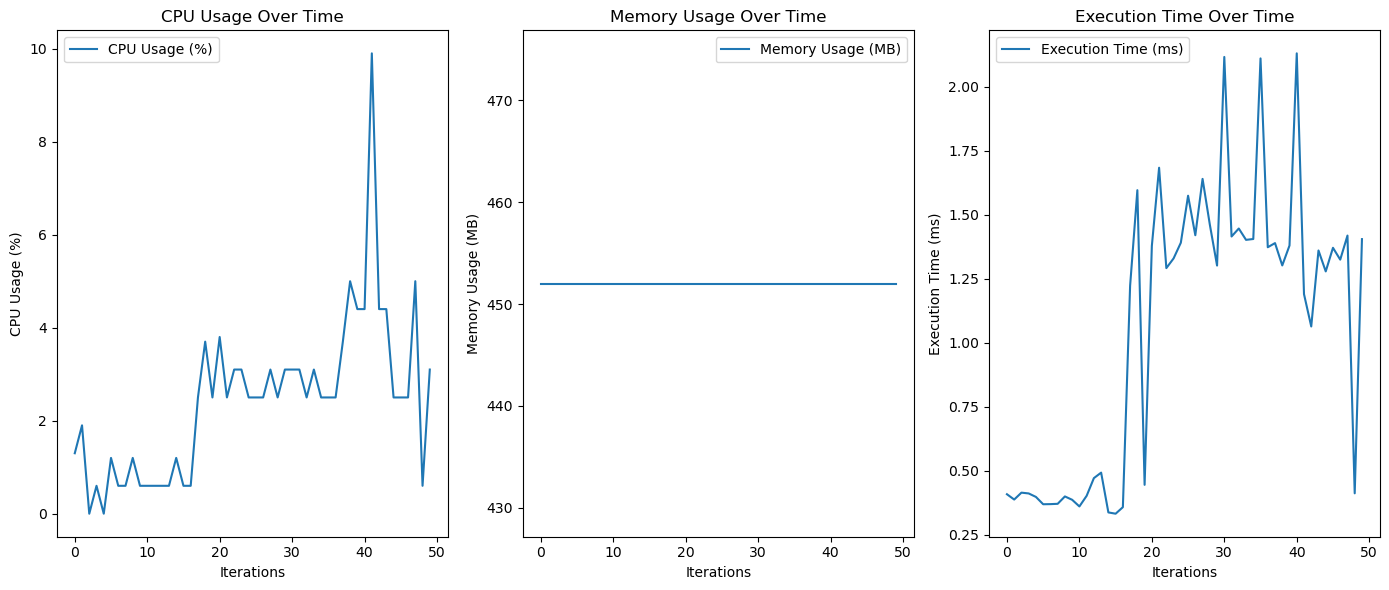

In [10]:
cpu_name = cpuinfo.get_cpu_info()['brand_raw'] # get only the brand name
print("CPU:", cpu_name)

# Lists to store performance data
cpu_usages = []
memory_usages = []
execution_times = []

# Function to predict preferences
def predict_preferences(user_id):
    # Weights are the similarities with other users
    weights = user_similarity_matrix[user_id]
    # Get the ratings from all users
    ratings = user_item_matrix_filled.values
    # Compute the weighted sum of ratings
    weighted_ratings = np.dot(weights, ratings)
    # Compute the sum of weights
    sum_of_weights = np.array([np.abs(weights).sum() for _ in range(ratings.shape[1])])
    # Predicted preferences
    predicted_preferences = weighted_ratings / sum_of_weights
    # Replace known values with original to not predict them
    predicted_preferences[user_item_matrix.iloc[user_id].notna().values] = user_item_matrix.iloc[user_id].values[user_item_matrix.iloc[user_id].notna().values]
    return predicted_preferences

# Measure start time and CPU usage
start_time = time.time()
cpu_usage_start = monitor_cpu()
memory_usage_start = monitor_memory()

# Predict preferences for all user-item pairs
all_predictions = np.zeros_like(user_item_matrix.values)
for i in range(user_item_matrix.shape[0]):
    start_time_iteration = time.time()
    all_predictions[i, :] = predict_preferences(i)
    # Capture performance metrics
    elapsed_time = time.time() - start_time_iteration
    execution_times.append(elapsed_time)
    cpu_usages.append(monitor_cpu())
    memory_usages.append(monitor_memory())

# Calculate MSE and MAE
mse = mean_squared_error(user_item_matrix_filled.values.flatten(), all_predictions.flatten())
mae = mean_absolute_error(user_item_matrix_filled.values.flatten(), all_predictions.flatten())
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

# Measure end time
memory_usage_end = monitor_memory()
end_time = time.time()

# Calculate total execution time and CPU usage
execution_time = end_time - start_time
cpu_usage_average = sum(cpu_usages) / len(cpu_usages)

print("Total execution time: %.3f seconds" % execution_time)
print("CPU usage: %.2f%%" % cpu_usage_average)
print("Memory usage: %.2f MB" % (memory_usage_end - memory_usage_start))

# Plotting performance metrics
plt.figure(figsize=(14, 6))

# CPU usage plot
plt.subplot(1, 3, 1)
plt.plot(cpu_usages, label='CPU Usage (%)')
plt.xlabel('Iterations')
plt.ylabel('CPU Usage (%)')
plt.title('CPU Usage Over Time')
plt.legend()

# Memory usage plot
plt.subplot(1, 3, 2)
plt.plot(np.array(memory_usages), label='Memory Usage (MB)')
plt.xlabel('Iterations')
plt.ylabel('Memory Usage (MB)')
plt.title('Memory Usage Over Time')
plt.legend()

# Execution time plot
plt.subplot(1, 3, 3)
plt.plot(np.array(execution_times)*1000, label='Execution Time (ms)')
plt.xlabel('Iterations')
plt.ylabel('Execution Time (ms)')
plt.title('Execution Time Over Time')
plt.legend()

plt.tight_layout()
plt.show()

### Inference (single user)

In [12]:
user_id = np.random.choice(users['user_id'])

# Measure start time and CPU usage
start_time = time.time()
memory_usage_start = monitor_memory()

top_activities = np.argsort(predict_preferences(user_id))[::-1][:5]

# Measure end time
end_time = time.time()
memory_usage_end = monitor_memory()

# Calculate total execution time and CPU usage
execution_time = end_time - start_time
cpu_usage = monitor_cpu()

print("Total execution time: %.3f seconds" % execution_time)
print("CPU usage: %.2f%%" % cpu_usage)
print("Memory usage: %.2f MB" % (memory_usage_end - memory_usage_start))

print("Top 5 activities for user %d:" % user_id, top_activities)

Total execution time: 0.002 seconds
CPU usage: 6.30%
Memory usage: 0.00 MB
Top 5 activities for user 19: [14 95 74 96 54]
